In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from collections import Counter

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


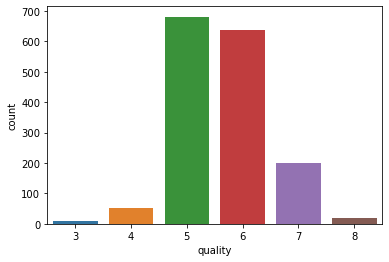

In [4]:
sns.countplot(x=df.quality);

In [83]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

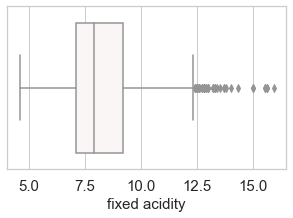

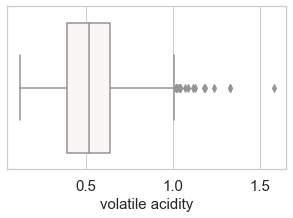

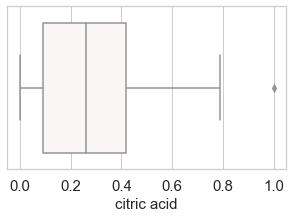

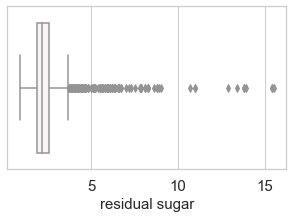

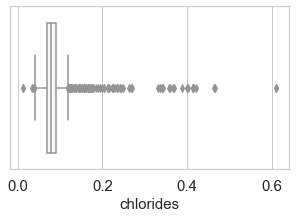

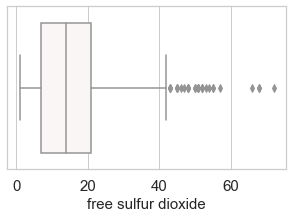

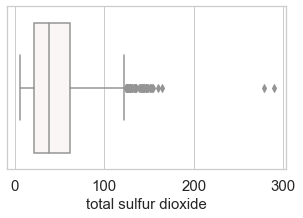

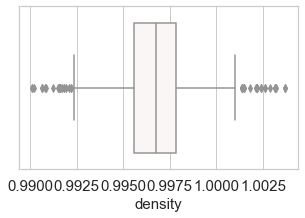

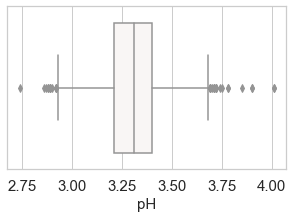

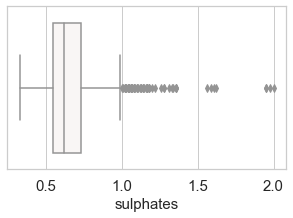

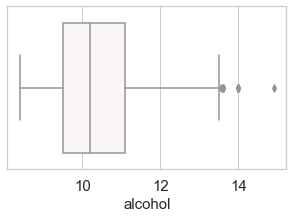

In [84]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop("quality", axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

### Podział na zbiór treningowy i testowy

In [85]:
# Podział na zbiór treningowy i testowy

X = df.drop("quality", axis=1)
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)
y_train.value_counts()

5    477
6    446
7    139
4     37
8     13
3      7
Name: quality, dtype: int64

### Oversampling / Undersampling

In [86]:
# # instantiating over and under sampler with RandomSampler

# over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
# over = RandomOverSampler(sampling_strategy=over_strategy)

# under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
# under = RandomUnderSampler(sampling_strategy=under_strategy)

# # first performing oversampling to minority class
# X_over, y_over = over.fit_resample(X_train, y_train)
# print(f"Oversampled: {Counter(y_over)}")

# # now to comine under sampling 
# X_combined, y_combined = under.fit_resample(X_over, y_over)
# print(f"Combined Random Sampling: {Counter(y_combined)}")

Oversampled: Counter({5: 477, 6: 446, 8: 177, 4: 177, 3: 177, 7: 139})
Combined Random Sampling: Counter({5: 382, 6: 357, 3: 177, 4: 177, 8: 177, 7: 139})


In [296]:
# # instantiating over and under sampler with SMOTE

# over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
# over = SMOTE(sampling_strategy=over_strategy, random_state=20)

# under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
# under = RandomUnderSampler(sampling_strategy=under_strategy)

# # now to comine over and under sampling
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

# X_combined, y_combined = pipeline.fit_resample(X_train, y_train)
# print(f"Oversampled: {Counter(y_combined)}")

Oversampled: Counter({5: 382, 6: 357, 3: 177, 4: 177, 8: 177, 7: 139})


In [660]:
over = {3: 377, 4: 377, 8: 377}  
# instantiating over and under sampler                 
over_strategy = SMOTE(sampling_strategy=over, random_state=20)

X_combined, y_combined = over_strategy.fit_resample(X_train, y_train)

In [661]:
y_combined.value_counts()

5    477
6    446
8    377
4    377
3    377
7    139
Name: quality, dtype: int64

### Usuwanie outlier'ów

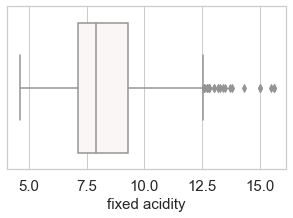

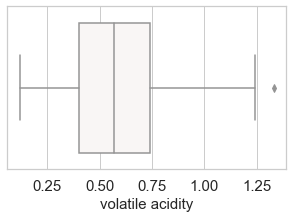

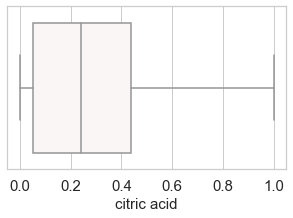

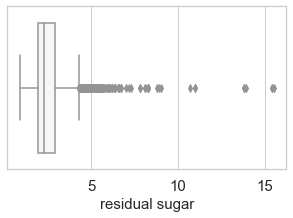

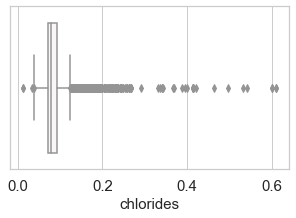

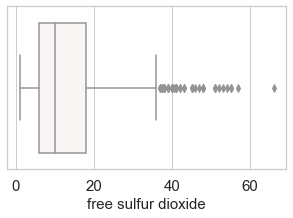

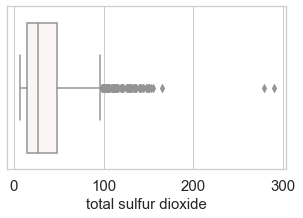

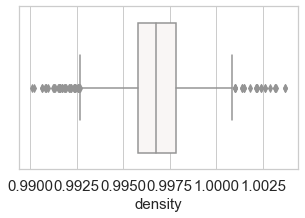

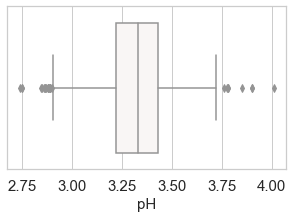

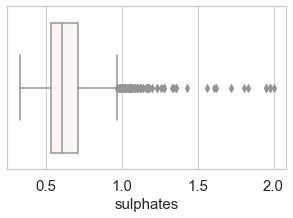

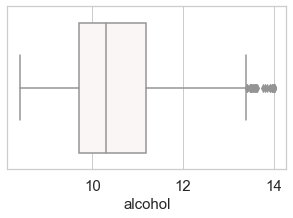

In [662]:
# Boxploty przed usunięciem outlier'ów

sns.set_theme(style="whitegrid")

list_columns_comb = list(X_combined.columns)

for column in list_columns_comb:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=X_combined[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [663]:
# Usuwanie outlier'ów z zestawu treningowego

def drop_outliers(dff, column):
    iqr = np.percentile(dff[column], 75) - np.percentile(dff[column], 25)
    dff.drop(dff[dff[column] < np.percentile(dff[column], 25) - 3.0 * iqr].index, inplace=True)
    dff.drop(dff[dff[column] > np.percentile(dff[column], 75) + 3.0 * iqr].index, inplace=True)
    return dff

In [664]:
df_train = pd.concat([X_combined, y_combined], axis=1)
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.1,0.710,0.00,1.9,0.080,14.0,35.0,0.9972,3.47,0.55,9.4,5
1,7.2,0.650,0.02,2.3,0.094,5.0,31.0,0.9993,3.67,0.80,9.7,5
2,6.9,0.490,0.10,2.3,0.074,12.0,30.0,0.9959,3.42,0.58,10.2,6
3,10.7,0.350,0.53,2.6,0.070,5.0,16.0,0.9972,3.15,0.65,11.0,8
4,7.3,0.695,0.00,2.5,0.075,3.0,13.0,0.9980,3.49,0.52,9.2,5


In [665]:
df_train.shape

(2193, 12)

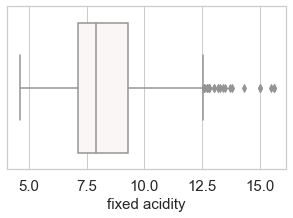

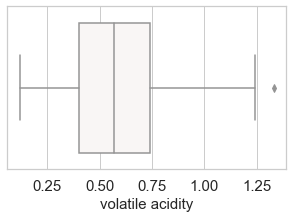

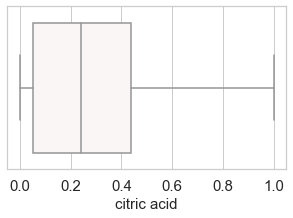

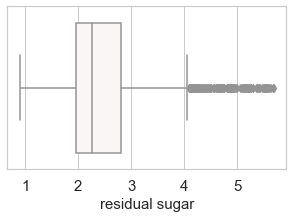

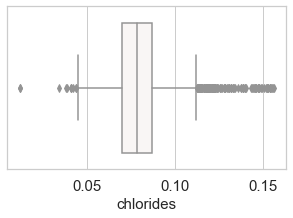

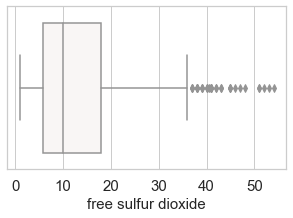

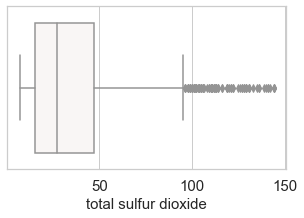

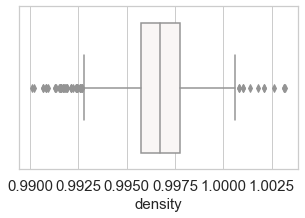

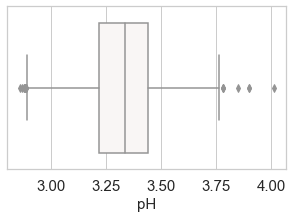

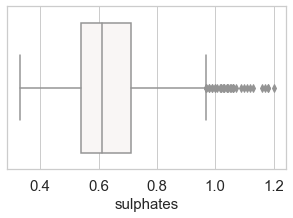

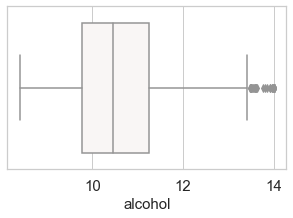

In [666]:
# Boxploty po usunięciu outlier'ów

for column in list_columns:
    drop_outliers(df_train, column=column)
    
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df_train[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [667]:
df_train.shape

(1983, 12)

In [668]:
X_train_outlier = df_train.drop("quality", axis=1)
y_train_outlier = df_train.quality

y_train_outlier.value_counts()

5    427
6    412
8    377
4    362
3    277
7    128
Name: quality, dtype: int64

In [669]:
# Usuwanie outlier'ów z zestawu testowego (z wykorzystaniem iqr i percentyli z zestawu treningowego)

def drop_outliers_test(df_train, df_test, column):
    iqr = np.percentile(df_train[column], 75) - np.percentile(df_train[column], 25)
    df_test.drop(df_test[df_test[column] < np.percentile(df_train[column], 25) - 3.0 * iqr].index, inplace=True)
    df_test.drop(df_test[df_test[column] > np.percentile(df_train[column], 75) + 3.0 * iqr].index, inplace=True)
    return df_test

In [670]:
# Sprawdzenie przed usunięciem

y_test.value_counts()

5    204
6    192
7     60
4     16
8      5
3      3
Name: quality, dtype: int64

In [671]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
435,12.3,0.39,0.63,2.30,0.091,6.0,18.0,1.00040,3.16,0.49,9.5,5
125,9.0,0.62,0.04,1.90,0.146,27.0,90.0,0.99840,3.16,0.70,9.4,5
1245,7.4,0.55,0.19,1.80,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,5
721,8.9,0.48,0.24,2.85,0.094,35.0,106.0,0.99820,3.10,0.53,9.2,5
289,11.6,0.42,0.53,3.30,0.105,33.0,98.0,1.00100,3.20,0.95,9.2,5


In [672]:
df_test.shape

(480, 12)

In [673]:
df_train_2 = pd.concat([X_combined, y_combined], axis=1)
df_train_2.shape

(2193, 12)

In [674]:
for column in list_columns:
    drop_outliers_test(df_train_2, df_test, column=column)

In [675]:
# Sprawdzenie po usunięciu

df_test.shape

(443, 12)

In [676]:
X_test_outlier = df_test.drop("quality", axis=1)
y_test_outlier = df_test.quality

y_test_outlier.value_counts()

5    186
6    183
7     53
4     14
8      4
3      3
Name: quality, dtype: int64

### Normalizacja

In [677]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train_outlier)

X_train_std = scaler.transform(X_train_outlier)

print(scaler.mean_, scaler.scale_)

[ 8.31462913  0.58121661  0.25613335  2.58229097  0.08071039 12.9106751
 35.52847033  0.99667644  3.33612597  0.63482528 10.63526585] [1.64365885e+00 2.17841532e-01 2.05702823e-01 9.12972449e-01
 1.77354292e-02 8.99652160e+00 2.62968943e+01 1.65861787e-03
 1.55433786e-01 1.29853167e-01 1.12195529e+00]


In [678]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test_outlier)

### KNN

In [680]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

In [681]:
# Model KNN

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train_std, y_train_outlier)

cross_val_score(model_KNN, X_train_std, y_train_outlier, cv=skf, scoring="roc_auc_ovr")

array([0.91704684, 0.89569723, 0.91864565, 0.9007037 , 0.90933852])

In [682]:
y_pred_KNN_train = model_KNN.predict(X_train_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_train_outlier, y_pred_KNN_train))

print("Raport klasyfikacyjny: \n", classification_report(y_train_outlier, y_pred_KNN_train))

Confusion matrix - tablica pomyłek
 [[277   0   0   0   0   0]
 [  0 358   2   2   0   0]
 [ 11  52 278  73   6   7]
 [  3  33  70 263  19  24]
 [  1   4  10  42  54  17]
 [  0   0   0   0   1 376]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.95      1.00      0.97       277
           4       0.80      0.99      0.89       362
           5       0.77      0.65      0.71       427
           6       0.69      0.64      0.66       412
           7       0.68      0.42      0.52       128
           8       0.89      1.00      0.94       377

    accuracy                           0.81      1983
   macro avg       0.80      0.78      0.78      1983
weighted avg       0.80      0.81      0.80      1983



In [683]:
model_KNN.score(X_test_std, y_test_outlier)

0.46275395033860045

In [684]:
y_pred_KNN = model_KNN.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_KNN))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_KNN))

Confusion matrix - tablica pomyłek
 [[ 1  2  0  0  0  0]
 [ 3  5  2  4  0  0]
 [ 2 46 89 42  7  0]
 [ 4 25 38 91 12 13]
 [ 0  3  1 21 17 11]
 [ 0  0  0  1  1  2]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.10      0.33      0.15         3
           4       0.06      0.36      0.11        14
           5       0.68      0.48      0.56       186
           6       0.57      0.50      0.53       183
           7       0.46      0.32      0.38        53
           8       0.08      0.50      0.13         4

    accuracy                           0.46       443
   macro avg       0.33      0.41      0.31       443
weighted avg       0.58      0.46      0.51       443



In [648]:
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_KNN = {
            "n_neighbors": list(range(2,31)),
            "weights": ["uniform"],
            "metric": ["minkowski"],
            "p": [1, 2],
            "algorithm": ['auto'],
            "leaf_size": [1, 2, 3, 4, 5, 10, 20]
             }

grid_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=skf, scoring="roc_auc_ovr", verbose=0, n_jobs=-1)
grid_KNN.fit(X_train_std, y_train_outlier)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'leaf_size': [1, 2, 3, 4, 5, 10, 20],
                         'metric': ['minkowski'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30],
                         'p': [1, 2], 'weights': ['uniform']},
             scoring='roc_auc_ovr')

In [649]:
print("Najlepsze parametry: ", grid_KNN.best_params_)
print("Najwyższy score: ", grid_KNN.best_score_)

Najlepsze parametry:  {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Najwyższy score:  0.8958618469504842


In [691]:
# Zastosowanie najlepszych parametrów dla modelu

model_KNN_best = KNeighborsClassifier(n_neighbors=8, p=1,)

model_KNN_best.fit(X_train_std, y_train_outlier)

cross_val_score(model_KNN_best, X_train_std, y_train_outlier, cv=skf, scoring="roc_auc_ovr")

array([0.9132119 , 0.90387079, 0.92582862, 0.90929457, 0.91931159])

In [692]:
roc_auc_score(y_test_outlier, model_KNN_best.predict_proba(X_test_std), multi_class='ovr')

0.730200961445098

In [693]:
model_KNN_best.score(X_train_std, y_train_outlier)

0.7856782652546647

In [694]:
y_pred_KNN2 = model_KNN_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_KNN2))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_KNN2, zero_division=1))

Confusion matrix - tablica pomyłek
 [[ 1  2  0  0  0  0]
 [ 3  8  0  3  0  0]
 [ 5 47 98 30  4  2]
 [ 4 24 32 91  5 27]
 [ 0  3  5 17  9 19]
 [ 0  0  0  1  0  3]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.08      0.33      0.12         3
           4       0.10      0.57      0.16        14
           5       0.73      0.53      0.61       186
           6       0.64      0.50      0.56       183
           7       0.50      0.17      0.25        53
           8       0.06      0.75      0.11         4

    accuracy                           0.47       443
   macro avg       0.35      0.47      0.30       443
weighted avg       0.63      0.47      0.53       443



In [689]:
# Zależność accuracy od liczby sąsiadów

train_acc = []
test_acc = []

for k in range(1, 30):
    
    knn = KNeighborsClassifier(n_neighbors=k, p=1)
    knn.fit(X_train_std, y_train_outlier)
    
    preds = knn.predict(X_train_std)
    score = cross_val_score(knn, X_train_std, y_train_outlier, cv=5, scoring="accuracy")
    train_acc.append(score.mean())
    
    preds2 = knn.predict(X_test_std)
    score2 = knn.score(X_test_std, y_test_outlier)
    test_acc.append(score2)

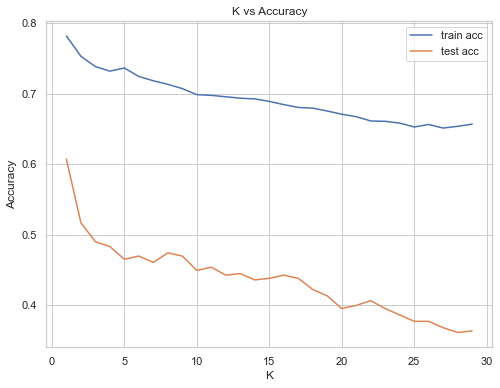

In [690]:
plt.figure(figsize=(8, 6))
plt.title('K vs Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.plot(range(1,30), train_acc, label='train acc')
plt.plot(range(1,30), test_acc, label='test acc')
plt.legend()

### XgBoost

In [695]:
%%capture --no-display
# XgBoost

model_xgb = xgb.XGBClassifier(random_state=12)
model_xgb.fit(X_train_std, y_train_outlier)

cross_val_score(model_xgb, X_train_std, y_train_outlier, cv=skf, scoring="roc_auc_ovr")

array([0.94631442, 0.94986906, 0.96204237, 0.960742  , 0.95653619])

In [696]:
y_pred_xgb_train = model_xgb.predict(X_train_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_train_outlier, y_pred_xgb_train))

print("Raport klasyfikacyjny: \n", classification_report(y_train_outlier, y_pred_xgb_train))

Confusion matrix - tablica pomyłek
 [[277   0   0   0   0   0]
 [  0 362   0   0   0   0]
 [  0   0 427   0   0   0]
 [  0   0   0 412   0   0]
 [  0   0   0   0 128   0]
 [  0   0   0   0   0 377]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       362
           5       1.00      1.00      1.00       427
           6       1.00      1.00      1.00       412
           7       1.00      1.00      1.00       128
           8       1.00      1.00      1.00       377

    accuracy                           1.00      1983
   macro avg       1.00      1.00      1.00      1983
weighted avg       1.00      1.00      1.00      1983



In [697]:
roc_auc_score(y_test_outlier, model_xgb.predict_proba(X_test_std), multi_class="ovr")

0.823993566463349

In [698]:
model_xgb.score(X_test_std, y_test_outlier)

0.6410835214446953

In [699]:
y_pred_xgb = model_xgb.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_xgb))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_xgb))

Confusion matrix - tablica pomyłek
 [[  0   2   0   1   0   0]
 [  0   0   7   7   0   0]
 [  0  13 137  34   2   0]
 [  2   2  40 120   9  10]
 [  0   2   1  18  26   6]
 [  0   0   1   0   2   1]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        14
           5       0.74      0.74      0.74       186
           6       0.67      0.66      0.66       183
           7       0.67      0.49      0.57        53
           8       0.06      0.25      0.10         4

    accuracy                           0.64       443
   macro avg       0.35      0.36      0.34       443
weighted avg       0.66      0.64      0.65       443



In [700]:
%%capture --no-display
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_xgb = {
            "n_estimators": [100, 150, 200, 300, 400],
            "max_depth": [2, 5, 10, 20, 30],
            "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
            "booster": ["gbtree", "dart"],
            "min_child_weight": [1, 2, 4, 6],
            "subsample": [0.5, 0.8],
            "colsample_bylevel": [0.5, 0.8],
            "reg_alpha": [1, 2, 5],
            "objective": ["multi:softmax", "reg:logistic"],
            "num_class": [6]
    
}

grid_xgb = GridSearchCV(model_xgb, param_grid=param_grid_xgb, cv=skf, scoring="roc_auc_ovr", verbose=0, n_jobs=-1)
grid_xgb.fit(X_train_std, y_train_outlier)

KeyboardInterrupt: 

In [329]:
print("Najlepsze parametry: ", grid_xgb.best_params_)
print("Najwyższy score: ", grid_xgb.best_score_)

Najlepsze parametry:  {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'num_class': 6, 'objective': 'multi:softmax', 'reg_alpha': 1}
Najwyższy score:  0.7222916334661355


In [701]:
%%capture --no-display
# Zastosowanie najlepszych parametrów dla modelu

model_xgb_best = xgb.XGBClassifier(random_state=12, booster='gbtree', learning_rate=0.1, 
                                   max_depth=10, n_estimators=150, num_class=6, 
                                   objective='multi:softmax', reg_alpha=1)

# (random_state=12, booster='gbtree', learning_rate=0.2, 
#                                    max_depth=20, n_estimators=150, objective='reg:logistic', 
#                                    reg_alpha=2, subsample=0.5, colsample_bylevel=0.5,
#                                    tree_method="approx")

model_xgb_best.fit(X_train_std, y_train_outlier)

cross_val_score(model_xgb, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")

array([0.9458067 , 0.94662196, 0.96057788, 0.95222337, 0.95987183])

In [702]:
roc_auc_score(y_test_outlier, model_xgb_best.predict_proba(X_test_std), multi_class="ovr")

0.8523205452914785

In [703]:
model_xgb_best.score(X_test_std, y_test_outlier)

0.6410835214446953

In [704]:
y_pred_xgb = model_xgb_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_xgb))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_xgb, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0   2   0   1   0   0]
 [  3   0   5   6   0   0]
 [  0  12 139  33   2   0]
 [  2   5  38 118  10  10]
 [  0   2   2  16  26   7]
 [  0   0   0   0   3   1]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        14
           5       0.76      0.75      0.75       186
           6       0.68      0.64      0.66       183
           7       0.63      0.49      0.55        53
           8       0.06      0.25      0.09         4

    accuracy                           0.64       443
   macro avg       0.35      0.36      0.34       443
weighted avg       0.67      0.64      0.66       443



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

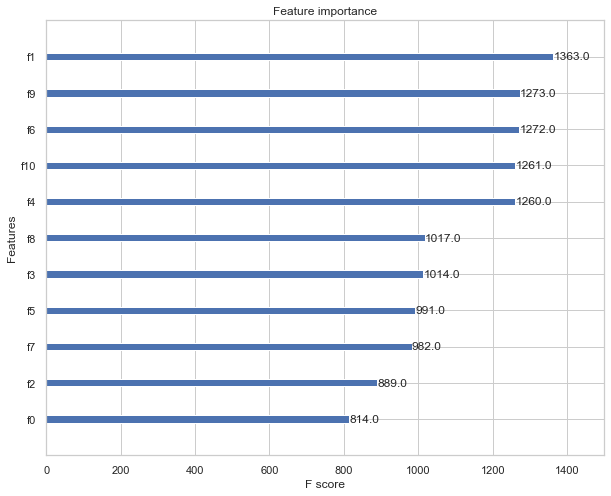

In [496]:
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 10, 8

xgb.plot_importance(model_xgb_best)

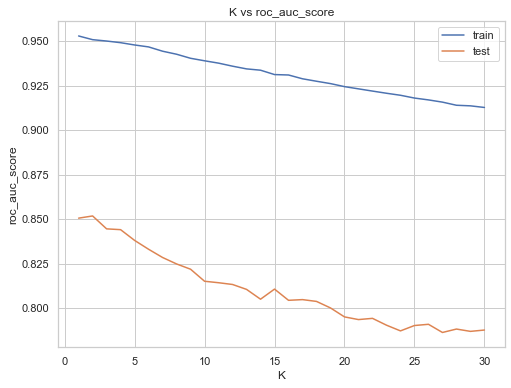

In [705]:
%%capture --no-display

scores_train = []
scores_test = []

for k in range(1, 31):
    xg = xgb.XGBClassifier(booster='gbtree', objective='multi:softmax', learning_rate=0.2, 
                            max_depth=20, n_estimators=150, num_class=6, reg_alpha=k, random_state=12)
    xg.fit(X_train_std, y_train_outlier)
    score = cross_val_score(xg, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")
    scores_train.append(score.mean())
    
    score2 = roc_auc_score(y_test_outlier, xg.predict_proba(X_test_std), multi_class="ovr")
    scores_test.append(score2)
    
    
plt.figure(figsize=(8, 6))
plt.title('K vs roc_auc_score')
plt.xlabel('K')
plt.ylabel('roc_auc_score')
plt.plot(range(1,31), scores_train, label='train')
plt.plot(range(1,31), scores_test, label='test')
plt.legend()

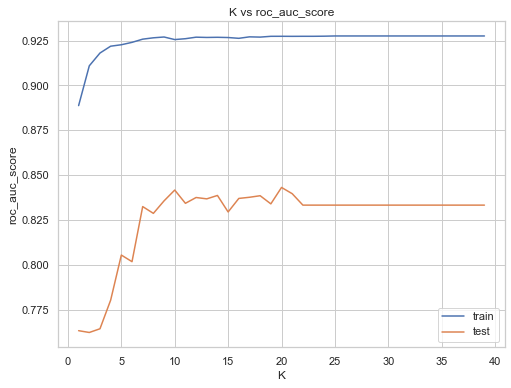

In [440]:
%%capture --no-display

scores_train = []
scores_test = []

for k in range(1, 40):
    xg = xgb.XGBClassifier(booster='gbtree', objective='multi:softmax', learning_rate=0.2, 
                            max_depth=k, n_estimators=150, num_class=6, reg_alpha=2, random_state=12)
    xg.fit(X_train_std, y_train_outlier)
    score = cross_val_score(xg, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")
    scores_train.append(score.mean())
    
    score2 = roc_auc_score(y_test_outlier, xg.predict_proba(X_test_std), multi_class="ovr")
    scores_test.append(score2)
    
    
plt.figure(figsize=(8, 6))
plt.title('K vs roc_auc_score')
plt.xlabel('K')
plt.ylabel('roc_auc_score')
plt.plot(range(1,40), scores_train, label='train')
plt.plot(range(1,40), scores_test, label='test')
plt.legend()

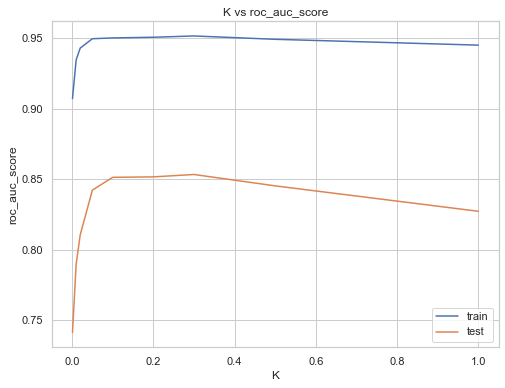

In [706]:
%%capture --no-display

scores_train = []
scores_test = []
list_lr = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]

for k in list_lr:
    xg = xgb.XGBClassifier(booster='gbtree', objective='multi:softmax', learning_rate=k, 
                            max_depth=20, n_estimators=150, num_class=6, reg_alpha=2, random_state=12)
    xg.fit(X_train_std, y_train_outlier)
    score = cross_val_score(xg, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")
    scores_train.append(score.mean())
    
    score2 = roc_auc_score(y_test_outlier, xg.predict_proba(X_test_std), multi_class="ovr")
    scores_test.append(score2)
    
    
plt.figure(figsize=(8, 6))
plt.title('K vs roc_auc_score')
plt.xlabel('K')
plt.ylabel('roc_auc_score')
plt.plot(list_lr, scores_train, label='train')
plt.plot(list_lr, scores_test, label='test')
plt.legend()

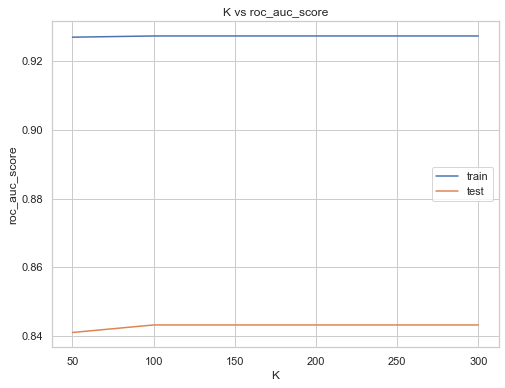

In [442]:
%%capture --no-display

scores_train = []
scores_test = []
list_n = [50, 100, 150, 200, 250, 300]

for k in list_n:
    xg = xgb.XGBClassifier(booster='gbtree', objective='multi:softmax', learning_rate=0.2, 
                            max_depth=20, n_estimators=k, num_class=6, reg_alpha=2, random_state=12)
    xg.fit(X_train_std, y_train_outlier)
    score = cross_val_score(xg, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")
    scores_train.append(score.mean())
    
    score2 = roc_auc_score(y_test_outlier, xg.predict_proba(X_test_std), multi_class="ovr")
    scores_test.append(score2)
    
    
plt.figure(figsize=(8, 6))
plt.title('K vs roc_auc_score')
plt.xlabel('K')
plt.ylabel('roc_auc_score')
plt.plot(list_n, scores_train, label='train')
plt.plot(list_n, scores_test, label='test')
plt.legend()

### Logistic Regresion

In [444]:
# Logistic Regression

model_LR = LogisticRegression()
model_LR.fit(X_train_std, y_train_outlier)

cross_val_score(model_LR, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")

array([0.8627892 , 0.88037694, 0.87299662, 0.87077219, 0.86738643])

In [445]:
roc_auc_score(y_test_outlier, model_LR.predict_proba(X_test_std), multi_class="ovr")

0.7679540009797593

In [446]:
model_LR.score(X_train_std, y_train_outlier)

0.6041500399042299

In [447]:
y_pred_LR = model_LR.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_LR))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_LR, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0   0   1   1   0   0]
 [  4   5   3   2   0   0]
 [  4  17 116  47   2   2]
 [  3   3  50  93  12  18]
 [  0   0   2  18   9  24]
 [  0   0   0   1   1   2]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.20      0.36      0.26        14
           5       0.67      0.62      0.64       188
           6       0.57      0.52      0.55       179
           7       0.38      0.17      0.23        53
           8       0.04      0.50      0.08         4

    accuracy                           0.51       440
   macro avg       0.31      0.36      0.29       440
weighted avg       0.57      0.51      0.53       440



In [478]:
model_LR_best = LogisticRegression(penalty="l2", C=1, 
                                   class_weight="balanced", 
                                   random_state=12, 
                                   solver="newton-cg", 
                                   multi_class="multinomial")
model_LR_best.fit(X_train_std, y_train_outlier)
cross_val_score(model_LR_best, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")

array([0.86379889, 0.87972974, 0.8723607 , 0.86716618, 0.868142  ])

In [479]:
roc_auc_score(y_test_outlier, model_LR_best.predict_proba(X_test_std), multi_class="ovr")

0.7467498428113465

In [480]:
model_LR_best.score(X_train_std, y_train_outlier)

0.5921787709497207

In [481]:
y_pred_LR = model_LR_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test_outlier, y_pred_LR))

print("Raport klasyfikacyjny: \n", classification_report(y_test_outlier, y_pred_LR, zero_division=1))

Confusion matrix - tablica pomyłek
 [[ 0  1  0  1  0  0]
 [ 5  6  1  2  0  0]
 [ 4 39 98 35  8  4]
 [ 5 12 43 51 47 21]
 [ 0  0  2 10 23 18]
 [ 0  0  0  0  1  3]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.10      0.43      0.17        14
           5       0.68      0.52      0.59       188
           6       0.52      0.28      0.37       179
           7       0.29      0.43      0.35        53
           8       0.07      0.75      0.12         4

    accuracy                           0.41       440
   macro avg       0.28      0.40      0.27       440
weighted avg       0.54      0.41      0.45       440



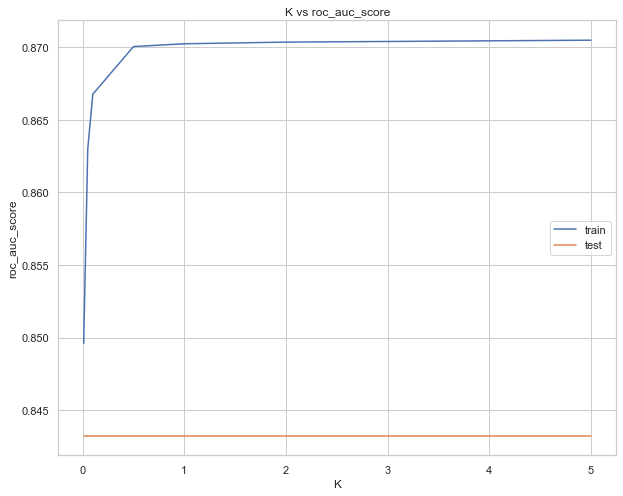

In [484]:
scores_train = []
scores_test = []

c_list = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]

for k in c_list:
    lr = LogisticRegression(penalty="l2", 
                            C=k, 
                            class_weight="balanced", 
                            random_state=12, 
                            solver="newton-cg", 
                            multi_class="multinomial")
    lr.fit(X_train_std, y_train_outlier)
    score = cross_val_score(lr, X_train_std, y_train_outlier, cv=5, scoring="roc_auc_ovr")
    scores_train.append(score.mean())
    
    score2 = roc_auc_score(y_test_outlier, xg.predict_proba(X_test_std), multi_class="ovr")
    scores_test.append(score2)
    
plt.figure(figsize=(10, 8))
plt.title("K vs roc_auc_score")
plt.xlabel("K")
plt.ylabel("roc_auc_score")
plt.plot(c_list, scores_train, label="train")
plt.plot(c_list, scores_test, label="test")
plt.legend()